In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "MIKC_MADS"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn049281,MARGKIQIKRIENSTNRQVTYSKRRNGLFKKANELTVLCDAKVSII...,155,1
1,Achn112721,MGRGKIEIKKIENANNRQVTFSKRRGGLVKKAKELAILCDAEVALI...,175,1
2,Achn135681,MGRGKIEIKRIENPINRQVTYSKRRNGIFKKAQELTVLCDAKVSII...,213,1
3,Achn143731,MGRGRVQLKRIENKINRQVTFSKRRGGLLKKANEISVLCDAEVALI...,155,1
4,Achn147701,MGRGKIVIRRIDNTTSRQVTFSKRRTGLLKKAKELEILCDAEVGLV...,220,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
44,0.007812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007812,0.000000,0.000000,...,0.000000,0.000000,0.007812,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
12341,0.002667,0.000000,0.010667,0.008000,0.000000,0.002667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.002667,0.000000,0.000000,0.002667,0.0,0.008000,0.0,0.0,0.000000
4163,0.012605,0.000000,0.000000,0.004202,0.000000,0.004202,0.004202,0.000000,0.004202,0.008403,...,0.000000,0.004202,0.012605,0.000000,0.000000,0.0,0.004202,0.0,0.0,0.000000
8862,0.018868,0.000000,0.003774,0.007547,0.000000,0.003774,0.000000,0.000000,0.003774,0.015094,...,0.015094,0.000000,0.000000,0.007547,0.011321,0.0,0.000000,0.0,0.0,0.018868
7893,0.001661,0.003322,0.000000,0.000000,0.006645,0.006645,0.000000,0.003322,0.003322,0.001661,...,0.001661,0.006645,0.001661,0.000000,0.008306,0.0,0.000000,0.0,0.0,0.003322


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (11047, 441)
X_test: (2762, 441)
y_train: (11047,)
y_test: (2762,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:04 466ms/step - accuracy: 0.5000 - loss: 0.6932

 38/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7944 - loss: 0.6531    

 76/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8581 - loss: 0.5420

111/139 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8849 - loss: 0.4630

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8990 - loss: 0.4151 - val_accuracy: 0.9769 - val_loss: 0.0706


Epoch 2/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0425

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0561

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.0533

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.0520

130/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0512

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0511 - val_accuracy: 0.9882 - val_loss: 0.0477


Epoch 3/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0458

 32/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0464

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0411

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0391

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0381

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0380 - val_accuracy: 0.9900 - val_loss: 0.0380


Epoch 4/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0224

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0267

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0273

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0285

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0298

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0303 - val_accuracy: 0.9905 - val_loss: 0.0320


Epoch 5/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0119

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0267

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0254

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0253

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0257

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0259 - val_accuracy: 0.9869 - val_loss: 0.0422


Epoch 6/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0037

 34/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0276

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0238

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0232

130/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0229

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0228 - val_accuracy: 0.9887 - val_loss: 0.0390


Epoch 7/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0460

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.0565

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0469

 94/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9860 - loss: 0.0410

124/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0373

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0359 - val_accuracy: 0.9914 - val_loss: 0.0277


Epoch 8/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0108

 32/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0083

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0103

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0117

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0122

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0123 - val_accuracy: 0.9914 - val_loss: 0.0274


Epoch 9/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0108

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0169

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0133

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0119

130/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0115

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9928 - val_loss: 0.0245


Epoch 10/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0021

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0047

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0055

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0058

129/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0061

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0061 - val_accuracy: 0.9923 - val_loss: 0.0264


Epoch 11/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0024

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0035

 62/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0044

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0055

122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0064

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0067 - val_accuracy: 0.9923 - val_loss: 0.0251


Epoch 12/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 9.9935e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0090    

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0077

 96/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0071

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0072

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0074 - val_accuracy: 0.9937 - val_loss: 0.0252


Epoch 13/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.2455e-04

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0037    

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0034

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0035

129/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0040

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0042 - val_accuracy: 0.9932 - val_loss: 0.0229


Epoch 14/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0015

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0027

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0030

 96/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0032

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0034

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0037 - val_accuracy: 0.9946 - val_loss: 0.0215


Epoch 15/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0026

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0026

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0034

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0038

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0040

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.9950 - val_loss: 0.0193


Epoch 16/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.5918e-04

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0023    

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0028

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0029

130/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0029

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0030 - val_accuracy: 0.9932 - val_loss: 0.0259


Epoch 17/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1657e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0079    

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0076

 96/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0067

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0063

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0062 - val_accuracy: 0.9937 - val_loss: 0.0256


Epoch 18/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.8839e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0036    

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0047

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0045

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0043

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0043 - val_accuracy: 0.9941 - val_loss: 0.0226


Epoch 19/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.3347e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0453    

 61/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0440

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0399

120/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0361

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0340 - val_accuracy: 0.9910 - val_loss: 0.0350


Epoch 20/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0041

 30/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9809 - loss: 0.0509

 62/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0355

 94/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0287

125/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0249

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0235 - val_accuracy: 0.9941 - val_loss: 0.0218


Epoch 21/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 0.0013

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0022

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0024

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0027

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0031

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9955 - val_loss: 0.0190


Epoch 22/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 4.1443e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.8744e-04

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0016    

 94/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0024

125/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0031

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9937 - val_loss: 0.0239


Epoch 23/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.3743e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0020    

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0038

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0041

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0040

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0040 - val_accuracy: 0.9946 - val_loss: 0.0214


Epoch 24/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.9566e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0016    

 64/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015

 96/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0017

128/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0021

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9932 - val_loss: 0.0227


Epoch 25/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.5497e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0031    

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0031

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0033

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0033

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0033 - val_accuracy: 0.9905 - val_loss: 0.0393


Epoch 26/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.0667e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0010    

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0012

 94/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0019

125/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0022

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9937 - val_loss: 0.0288


Epoch 27/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.2401e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.5033e-04

 63/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0013    

 94/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0015

125/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0016

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0016 - val_accuracy: 0.9937 - val_loss: 0.0293


Epoch 28/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.5503e-04

 29/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0011    

 60/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0019

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0018

122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0017

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9937 - val_loss: 0.0307


Epoch 29/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9844 - loss: 0.0662

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0084

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0051

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0038

130/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0030

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9937 - val_loss: 0.0313


Epoch 30/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.3875e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3991e-04

 61/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.5495e-04

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.4398e-04

122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.3868e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.4689e-04 - val_accuracy: 0.9910 - val_loss: 0.0466


Epoch 31/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1225e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0020    

 61/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0049

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0050

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0048

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0047 - val_accuracy: 0.9946 - val_loss: 0.0250



[Train Accuracy: 99.92% - Test Accuracy: 98.81%]


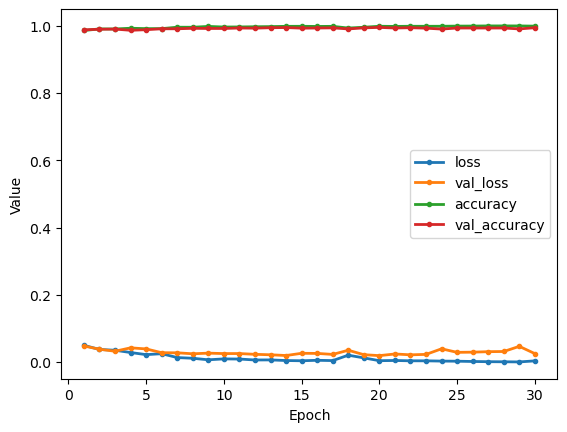

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/87 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


 1/87 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
44,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
12341,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
4163,0.004219,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
8862,0.003788,0.0,0.0,0.003788,0.0,0.0,0.0,0.0,0.0,0.007576,...,0.007576,0.0,0.0,0.0,0.007576,0.0,0.0,0.0,0.0,0.003788
7893,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (11047, 8968)
X_test: (2762, 8968)
y_train: (11047,)
y_test: (2762,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,296,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,339,329 (8.92 MB)

 Trainable params: 2,339,329 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:22 601ms/step - accuracy: 0.5156 - loss: 0.6932

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5082 - loss: 0.6927    

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5477 - loss: 0.6907

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5976 - loss: 0.6863

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6402 - loss: 0.6781

 41/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6742 - loss: 0.6643

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7018 - loss: 0.6446

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7245 - loss: 0.6214

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7435 - loss: 0.5973

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7597 - loss: 0.5738

 81/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7736 - loss: 0.5516

 89/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7857 - loss: 0.5309

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7976 - loss: 0.5093

107/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8081 - loss: 0.4895

115/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8163 - loss: 0.4733

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8238 - loss: 0.4583

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8306 - loss: 0.4443

139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8375 - loss: 0.4297 - val_accuracy: 0.9932 - val_loss: 0.0325


Epoch 2/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0042

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0199 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.0355

 26/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9935 - loss: 0.0398

 34/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9930 - loss: 0.0406

 42/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9929 - loss: 0.0403

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9928 - loss: 0.0398

 58/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9927 - loss: 0.0392

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9927 - loss: 0.0385

 74/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9928 - loss: 0.0377

 82/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9929 - loss: 0.0371

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9930 - loss: 0.0364

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9931 - loss: 0.0358

108/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9932 - loss: 0.0350

116/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9934 - loss: 0.0343

125/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9935 - loss: 0.0337

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9936 - loss: 0.0332

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9936 - loss: 0.0328 - val_accuracy: 0.9941 - val_loss: 0.0300


Epoch 3/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 0.0062

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0048 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0054

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0087

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0101

 41/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0116

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0123

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0129

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0133

 74/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0138

 82/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0141

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0144

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0146

107/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0147

115/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0147

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0148

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0148

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9973 - loss: 0.0148 - val_accuracy: 0.9932 - val_loss: 0.0289


Epoch 4/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 0.0013

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9936 - loss: 0.0324 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9955 - loss: 0.0238

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9963 - loss: 0.0201

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9966 - loss: 0.0185

 41/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9968 - loss: 0.0175

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9970 - loss: 0.0165

 58/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0157

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0151

 74/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0146

 82/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0141

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0137

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0133

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0130

115/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0128

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0126

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0124

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9976 - loss: 0.0122 - val_accuracy: 0.9950 - val_loss: 0.0231


Epoch 5/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.9290e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0064     

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0078

 26/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0083

 35/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9970 - loss: 0.0081

 44/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9970 - loss: 0.0079

 53/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9971 - loss: 0.0076

 62/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9972 - loss: 0.0072

 70/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0070

 78/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0068

 87/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9974 - loss: 0.0066

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9975 - loss: 0.0064

103/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0062

111/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9976 - loss: 0.0061

119/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0059

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0058

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9978 - loss: 0.0057

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9978 - loss: 0.0056 - val_accuracy: 0.9955 - val_loss: 0.0175


Epoch 6/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.9436e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2242e-04 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0493e-04

 26/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5374e-04

 34/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8989e-04

 42/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4895e-04

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9324e-04

 58/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1783e-04

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3032e-04

 74/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5303e-04

 82/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6736e-04

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7332e-04

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.7311e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6920e-04

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6217e-04

122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5304e-04

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5178e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4655e-04

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3530e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 8.2802e-04 - val_accuracy: 0.9968 - val_loss: 0.0183


Epoch 7/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.0456e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4703e-04 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6071e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5374e-04

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4930e-04

 42/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4352e-04

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3914e-04

 58/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3583e-04

 67/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3390e-04

 75/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3268e-04

 83/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3121e-04

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2983e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2838e-04

107/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2663e-04

115/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2473e-04

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2279e-04

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2098e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.1945e-04 - val_accuracy: 0.9964 - val_loss: 0.0210


Epoch 8/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.8394e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5005e-04 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1134e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8425e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0068e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3336e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7673e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3399e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9712e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6476e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3662e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1409e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9556e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7952e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6498e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5068e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3735e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.2610e-05 - val_accuracy: 0.9964 - val_loss: 0.0221


Epoch 9/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.1089e-06

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3038e-06 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0443e-06

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6647e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0934e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2588e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3192e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3386e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3426e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3344e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3242e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3117e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3041e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2895e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2695e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2557e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2493e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.2383e-05 - val_accuracy: 0.9964 - val_loss: 0.0235


Epoch 10/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 5.7227e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2197e-05 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4303e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0525e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8671e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6736e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4893e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3187e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1710e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0335e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9105e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7857e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6916e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6445e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6082e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5695e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5334e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4967e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.4923e-05 - val_accuracy: 0.9964 - val_loss: 0.0227


Epoch 11/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.4055e-06

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2231e-05 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1528e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0715e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0014e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8176e-06

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8563e-06

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0623e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1275e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1639e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1873e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2077e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2571e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2966e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3266e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3508e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3670e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3811e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.3856e-05 - val_accuracy: 0.9968 - val_loss: 0.0238


Epoch 12/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.1453e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2669e-05 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2216e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1269e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0369e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7639e-06

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5149e-06

 59/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5856e-06

 68/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7299e-06

 76/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0072e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0347e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0524e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0613e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0640e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0621e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0576e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0514e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0458e-05 - val_accuracy: 0.9968 - val_loss: 0.0245


Epoch 13/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.4603e-06

 10/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2781e-06 

 18/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6154e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7073e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6571e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6070e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5536e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4970e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4499e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4157e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3797e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3454e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3138e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2840e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2575e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2313e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2117e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.1925e-05 - val_accuracy: 0.9964 - val_loss: 0.0261


Epoch 14/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 3.5172e-07

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2514e-06 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7225e-06

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9465e-06

 33/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9195e-06

 41/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8391e-06

 49/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7869e-06

 57/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7347e-06

 65/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7714e-06

 73/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9056e-06

 81/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0872e-06

 89/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2447e-06

 97/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3526e-06

105/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4202e-06

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4522e-06

121/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4799e-06

129/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4896e-06

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5094e-06

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.5188e-06 - val_accuracy: 0.9968 - val_loss: 0.0260


Epoch 15/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.7354e-06

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8234e-06 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7605e-06

 25/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8887e-06

 34/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9373e-06

 42/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0619e-06

 50/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4235e-06

 59/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7098e-06

 68/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9016e-06

 77/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0531e-06

 86/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1506e-06

 95/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2184e-06

104/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3353e-06

113/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4129e-06

122/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4637e-06

131/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5060e-06

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.5363e-06 - val_accuracy: 0.9968 - val_loss: 0.0260


Epoch 16/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.2137e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1210e-06 

 17/139 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7512e-06

 26/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1011e-06

 35/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0834e-06

 43/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0815e-06

 51/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0409e-06

 60/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9957e-06

 68/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9724e-06

 76/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9605e-06

 85/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9651e-06

 93/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9845e-06

101/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0053e-06

109/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0163e-06

117/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0217e-06

125/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0186e-06

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0102e-06

139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.0018e-06 - val_accuracy: 0.9968 - val_loss: 0.0265



[Train Accuracy: 100.00% - Test Accuracy: 99.28%]


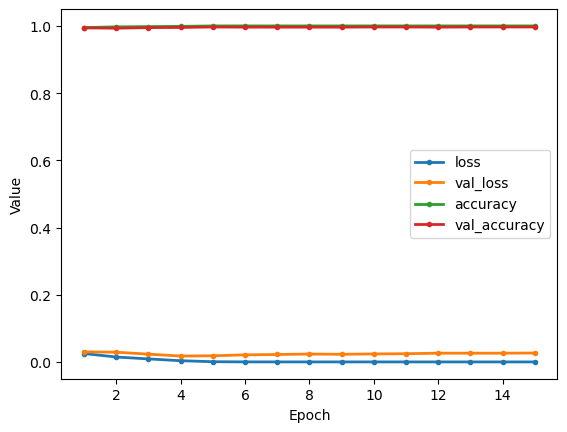

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/87 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

60/87 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


 1/87 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

55/87 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003802,...,0.0,0.003802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      39,885,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,927,041 (152.31 MB)

 Trainable params: 39,927,041 (152.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 1:47 776ms/step - accuracy: 0.4062 - loss: 0.6932

  2/139 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.4062 - loss: 0.6933 

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 0.4201 - loss: 0.6933

  4/139 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.4303 - loss: 0.6933

  5/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.4399 - loss: 0.6933

  6/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.4534 - loss: 0.6933

  7/139 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.4642 - loss: 0.6932

  8/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.4718 - loss: 0.6932

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.4790 - loss: 0.6932

 10/139 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.4849 - loss: 0.6931

 11/139 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.4892 - loss: 0.6931

 12/139 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.4939 - loss: 0.6930

 13/139 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.4990 - loss: 0.6929

 14/139 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.5050 - loss: 0.6929

 15/139 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.5118 - loss: 0.6928

 16/139 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.5187 - loss: 0.6927

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.5256 - loss: 0.6926

 18/139 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5327 - loss: 0.6925

 19/139 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.5397 - loss: 0.6924

 20/139 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.5466 - loss: 0.6923

 21/139 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.5534 - loss: 0.6922

 22/139 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.5602 - loss: 0.6920

 23/139 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.5668 - loss: 0.6918

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5734 - loss: 0.6917

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.5798 - loss: 0.6914

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5861 - loss: 0.6912

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.5921 - loss: 0.6910

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.5979 - loss: 0.6907

 29/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.6034 - loss: 0.6904

 30/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.6088 - loss: 0.6901

 31/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6141 - loss: 0.6897

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.6192 - loss: 0.6893

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.6242 - loss: 0.6889

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6291 - loss: 0.6885

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6339 - loss: 0.6880

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6386 - loss: 0.6875

 37/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.6431 - loss: 0.6869

 38/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.6476 - loss: 0.6863

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6519 - loss: 0.6856

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6562 - loss: 0.6849

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6603 - loss: 0.6842

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6643 - loss: 0.6834

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6682 - loss: 0.6825

 44/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6721 - loss: 0.6816

 45/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.6758 - loss: 0.6807

 46/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.6795 - loss: 0.6797

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.6830 - loss: 0.6786

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.6865 - loss: 0.6775

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.6899 - loss: 0.6763

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.6932 - loss: 0.6751

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.6965 - loss: 0.6738

 52/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.6997 - loss: 0.6725

 53/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.7027 - loss: 0.6711

 54/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7058 - loss: 0.6697

 55/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7087 - loss: 0.6681

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7116 - loss: 0.6666

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7144 - loss: 0.6650

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7172 - loss: 0.6633

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7199 - loss: 0.6616

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7226 - loss: 0.6598

 61/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7252 - loss: 0.6580

 62/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7277 - loss: 0.6562 

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7301 - loss: 0.6543

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7326 - loss: 0.6524

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7349 - loss: 0.6505

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7373 - loss: 0.6485

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7395 - loss: 0.6465

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.7418 - loss: 0.6445

 69/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.7439 - loss: 0.6424

 70/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.7461 - loss: 0.6404

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.7482 - loss: 0.6383

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.7502 - loss: 0.6361

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.7522 - loss: 0.6340

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.7542 - loss: 0.6318

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.7562 - loss: 0.6296

 76/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.7581 - loss: 0.6274

 77/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7600 - loss: 0.6252

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7618 - loss: 0.6230

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7636 - loss: 0.6207

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7654 - loss: 0.6185

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7671 - loss: 0.6163

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7689 - loss: 0.6140

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7705 - loss: 0.6118

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.7722 - loss: 0.6095

 85/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7738 - loss: 0.6073

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7754 - loss: 0.6050

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7770 - loss: 0.6028

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7786 - loss: 0.6005

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7801 - loss: 0.5983

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7816 - loss: 0.5960

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.7830 - loss: 0.5938

 92/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7845 - loss: 0.5916

 93/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7859 - loss: 0.5894

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7873 - loss: 0.5872

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7887 - loss: 0.5850

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7901 - loss: 0.5828

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7914 - loss: 0.5806

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7928 - loss: 0.5784

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.7941 - loss: 0.5763

100/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7954 - loss: 0.5741

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7966 - loss: 0.5720

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7979 - loss: 0.5698

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7991 - loss: 0.5677

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8003 - loss: 0.5656

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8015 - loss: 0.5635

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8027 - loss: 0.5614

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8039 - loss: 0.5594

108/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8050 - loss: 0.5573

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8062 - loss: 0.5553

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8073 - loss: 0.5533

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8084 - loss: 0.5512

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8095 - loss: 0.5492

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8106 - loss: 0.5472

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8116 - loss: 0.5452

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8127 - loss: 0.5433

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8137 - loss: 0.5413

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8147 - loss: 0.5393

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8157 - loss: 0.5374

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8167 - loss: 0.5355

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8177 - loss: 0.5336

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8187 - loss: 0.5317

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8196 - loss: 0.5298

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8206 - loss: 0.5279

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8215 - loss: 0.5261

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8224 - loss: 0.5242

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8234 - loss: 0.5224

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8243 - loss: 0.5206

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8251 - loss: 0.5188

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8260 - loss: 0.5170

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8269 - loss: 0.5153

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.8277 - loss: 0.5135

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8286 - loss: 0.5118

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8294 - loss: 0.5100

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8303 - loss: 0.5083

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8311 - loss: 0.5066

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8319 - loss: 0.5049

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8327 - loss: 0.5032

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8335 - loss: 0.5015

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8342 - loss: 0.4999

139/139 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.8350 - loss: 0.4983 - val_accuracy: 0.9910 - val_loss: 0.0500


Epoch 2/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - accuracy: 1.0000 - loss: 0.0017

  2/139 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 0.0052

  3/139 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 1.0000 - loss: 0.0068

  4/139 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 1.0000 - loss: 0.0074

  5/139 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 1.0000 - loss: 0.0075

  6/139 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9996 - loss: 0.0102

  7/139 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9993 - loss: 0.0117

  8/139 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9992 - loss: 0.0127

  9/139 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.9991 - loss: 0.0132

 10/139 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9988 - loss: 0.0149

 11/139 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - accuracy: 0.9987 - loss: 0.0162

 12/139 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.9986 - loss: 0.0170

 13/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.9985 - loss: 0.0176

 14/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.9984 - loss: 0.0186

 15/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.9982 - loss: 0.0194

 16/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.9981 - loss: 0.0200

 17/139 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.9980 - loss: 0.0204

 18/139 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.9979 - loss: 0.0207

 19/139 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.9977 - loss: 0.0213

 20/139 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.9976 - loss: 0.0221

 21/139 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.9974 - loss: 0.0228

 22/139 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.9973 - loss: 0.0233

 23/139 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.9972 - loss: 0.0238

 24/139 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.9970 - loss: 0.0242

 25/139 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.9969 - loss: 0.0245

 26/139 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.9968 - loss: 0.0248

 27/139 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.9967 - loss: 0.0251

 28/139 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.9966 - loss: 0.0254

 29/139 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9965 - loss: 0.0256

 30/139 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9964 - loss: 0.0258

 31/139 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9964 - loss: 0.0260

 32/139 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9963 - loss: 0.0261

 33/139 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9962 - loss: 0.0262

 34/139 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9962 - loss: 0.0263

 35/139 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.9961 - loss: 0.0263

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9961 - loss: 0.0263

 37/139 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9961 - loss: 0.0264

 38/139 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9960 - loss: 0.0264

 39/139 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9960 - loss: 0.0264

 40/139 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9960 - loss: 0.0263

 41/139 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9959 - loss: 0.0263

 42/139 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9959 - loss: 0.0263

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9959 - loss: 0.0262

 44/139 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9959 - loss: 0.0262

 45/139 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9959 - loss: 0.0261

 46/139 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9959 - loss: 0.0262

 47/139 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.9958 - loss: 0.0262

 48/139 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9958 - loss: 0.0262

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9958 - loss: 0.0263

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9958 - loss: 0.0263

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9957 - loss: 0.0263

 52/139 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9957 - loss: 0.0263

 53/139 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9957 - loss: 0.0263

 54/139 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9957 - loss: 0.0263

 55/139 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9957 - loss: 0.0263

 56/139 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9957 - loss: 0.0263

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9956 - loss: 0.0264

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9956 - loss: 0.0264

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9956 - loss: 0.0264

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9956 - loss: 0.0264

 61/139 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9956 - loss: 0.0264

 62/139 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9956 - loss: 0.0263

 63/139 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9956 - loss: 0.0263

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9955 - loss: 0.0263

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9955 - loss: 0.0263 

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9955 - loss: 0.0263

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9955 - loss: 0.0262

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9955 - loss: 0.0262

 69/139 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.9955 - loss: 0.0262

 70/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9955 - loss: 0.0262

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9955 - loss: 0.0262

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9955 - loss: 0.0262

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9955 - loss: 0.0261

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9954 - loss: 0.0261

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9954 - loss: 0.0261

 76/139 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9954 - loss: 0.0261

 77/139 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9954 - loss: 0.0260

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9954 - loss: 0.0260

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9954 - loss: 0.0260

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9954 - loss: 0.0259

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9954 - loss: 0.0259

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9954 - loss: 0.0258

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9954 - loss: 0.0258

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9954 - loss: 0.0258

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9954 - loss: 0.0257

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9954 - loss: 0.0257

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0256

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0256

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0255

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0255

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0254

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0254

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0253

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9954 - loss: 0.0253

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9954 - loss: 0.0252

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9954 - loss: 0.0252

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9955 - loss: 0.0251

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9955 - loss: 0.0251

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9955 - loss: 0.0250

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9955 - loss: 0.0250

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9955 - loss: 0.0249

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9955 - loss: 0.0249

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9955 - loss: 0.0249

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9955 - loss: 0.0248

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9955 - loss: 0.0248

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9955 - loss: 0.0247

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9955 - loss: 0.0247

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9955 - loss: 0.0247

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9955 - loss: 0.0247

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9955 - loss: 0.0246

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9955 - loss: 0.0246

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9955 - loss: 0.0246

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9955 - loss: 0.0246

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9955 - loss: 0.0245

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9955 - loss: 0.0245

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.9955 - loss: 0.0245

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9955 - loss: 0.0245

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9955 - loss: 0.0244

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9955 - loss: 0.0244

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9955 - loss: 0.0244

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9955 - loss: 0.0244

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9955 - loss: 0.0243

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9955 - loss: 0.0243

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9955 - loss: 0.0243

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9955 - loss: 0.0242

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9955 - loss: 0.0242

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9955 - loss: 0.0242

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9955 - loss: 0.0242

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9955 - loss: 0.0241

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9955 - loss: 0.0241

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9955 - loss: 0.0241

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9955 - loss: 0.0241

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9955 - loss: 0.0240

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9955 - loss: 0.0240

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9955 - loss: 0.0240

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9955 - loss: 0.0240

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9955 - loss: 0.0239

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9955 - loss: 0.0239

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9955 - loss: 0.0239

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9955 - loss: 0.0239 - val_accuracy: 0.9932 - val_loss: 0.0378


Epoch 3/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 28s 205ms/step - accuracy: 1.0000 - loss: 0.0023

  2/139 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 0.9961 - loss: 0.0271

  3/139 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.9957 - loss: 0.0298

  4/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9958 - loss: 0.0291

  5/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9960 - loss: 0.0277

  6/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9962 - loss: 0.0263

  7/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9964 - loss: 0.0249

  8/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9966 - loss: 0.0236

  9/139 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.9966 - loss: 0.0236

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9967 - loss: 0.0234

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9967 - loss: 0.0231

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9968 - loss: 0.0227

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9968 - loss: 0.0223

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9969 - loss: 0.0218

 15/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9970 - loss: 0.0214

 16/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9970 - loss: 0.0210

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9971 - loss: 0.0206

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9972 - loss: 0.0202

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9972 - loss: 0.0198

 20/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9972 - loss: 0.0196

 21/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9973 - loss: 0.0194

 22/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9973 - loss: 0.0193

 23/139 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.9972 - loss: 0.0194

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9972 - loss: 0.0194

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9972 - loss: 0.0194

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9972 - loss: 0.0194

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9972 - loss: 0.0194

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9972 - loss: 0.0193

 29/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9972 - loss: 0.0193

 30/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9972 - loss: 0.0193

 31/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9972 - loss: 0.0193

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9972 - loss: 0.0192

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9972 - loss: 0.0192

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9972 - loss: 0.0192

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9972 - loss: 0.0191

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.9972 - loss: 0.0190

 37/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.9972 - loss: 0.0190

 38/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9972 - loss: 0.0189

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9972 - loss: 0.0189

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9972 - loss: 0.0188

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9972 - loss: 0.0187

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9972 - loss: 0.0186

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9972 - loss: 0.0186

 44/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.9972 - loss: 0.0185

 45/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9972 - loss: 0.0185

 46/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.9972 - loss: 0.0184

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9972 - loss: 0.0184

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9972 - loss: 0.0183

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9972 - loss: 0.0183

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9972 - loss: 0.0183

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9972 - loss: 0.0182

 52/139 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9972 - loss: 0.0182

 53/139 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9972 - loss: 0.0182

 54/139 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9972 - loss: 0.0181

 55/139 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9972 - loss: 0.0181

 56/139 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9972 - loss: 0.0181

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9972 - loss: 0.0180

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9972 - loss: 0.0180

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9972 - loss: 0.0180

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9972 - loss: 0.0179

 61/139 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9972 - loss: 0.0179

 62/139 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9972 - loss: 0.0179

 63/139 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9972 - loss: 0.0179

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9972 - loss: 0.0178

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9972 - loss: 0.0178 

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9972 - loss: 0.0178

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9972 - loss: 0.0178

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9972 - loss: 0.0177

 69/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9972 - loss: 0.0177

 70/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9972 - loss: 0.0177

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9972 - loss: 0.0177

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9972 - loss: 0.0177

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9972 - loss: 0.0176

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9972 - loss: 0.0176

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9972 - loss: 0.0176

 76/139 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9972 - loss: 0.0176

 77/139 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9972 - loss: 0.0175

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9972 - loss: 0.0175

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9972 - loss: 0.0175

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9972 - loss: 0.0175

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9972 - loss: 0.0175

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9972 - loss: 0.0175

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.9972 - loss: 0.0174

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9972 - loss: 0.0174

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9972 - loss: 0.0174

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9972 - loss: 0.0174

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9972 - loss: 0.0173

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9972 - loss: 0.0173

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.9972 - loss: 0.0173

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9972 - loss: 0.0172

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9972 - loss: 0.0172

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9972 - loss: 0.0172

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.9972 - loss: 0.0171

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9972 - loss: 0.0171

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9972 - loss: 0.0171

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9972 - loss: 0.0170

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9972 - loss: 0.0170

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9972 - loss: 0.0170

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9972 - loss: 0.0169

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9972 - loss: 0.0169

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9972 - loss: 0.0169

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9972 - loss: 0.0168

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9973 - loss: 0.0168

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9973 - loss: 0.0168

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9973 - loss: 0.0167

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9973 - loss: 0.0167

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9973 - loss: 0.0167

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9973 - loss: 0.0166

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9973 - loss: 0.0166

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9973 - loss: 0.0166

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9973 - loss: 0.0166

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9973 - loss: 0.0166

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9973 - loss: 0.0166

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9973 - loss: 0.0165

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9973 - loss: 0.0165

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9973 - loss: 0.0165

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9973 - loss: 0.0165

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9973 - loss: 0.0165

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9973 - loss: 0.0165

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9973 - loss: 0.0164

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9973 - loss: 0.0164

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9973 - loss: 0.0164

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9973 - loss: 0.0164

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9973 - loss: 0.0164

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9973 - loss: 0.0163

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9973 - loss: 0.0163

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9973 - loss: 0.0163

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9973 - loss: 0.0163

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9973 - loss: 0.0163

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9973 - loss: 0.0162

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9973 - loss: 0.0162

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9973 - loss: 0.0162

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9973 - loss: 0.0162

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9973 - loss: 0.0162

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9973 - loss: 0.0161

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9973 - loss: 0.0161

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9973 - loss: 0.0161

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9973 - loss: 0.0161

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9973 - loss: 0.0161

139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9973 - loss: 0.0160 - val_accuracy: 0.9928 - val_loss: 0.0364


Epoch 4/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 27s 196ms/step - accuracy: 1.0000 - loss: 0.0021

  2/139 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 1.0000 - loss: 0.0019

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 0.0019

  4/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 1.0000 - loss: 0.0018

  5/139 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 0.0018

  6/139 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 0.0018

  7/139 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 0.0018

  8/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 0.0018

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9998 - loss: 0.0024

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9997 - loss: 0.0028

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9996 - loss: 0.0031

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9994 - loss: 0.0039

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9992 - loss: 0.0051

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.9990 - loss: 0.0060

 15/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9988 - loss: 0.0068

 16/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9987 - loss: 0.0074

 17/139 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.9986 - loss: 0.0079

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.9985 - loss: 0.0083

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9984 - loss: 0.0087

 20/139 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9984 - loss: 0.0090

 21/139 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9983 - loss: 0.0092

 22/139 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9982 - loss: 0.0094

 23/139 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9982 - loss: 0.0096

 24/139 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9981 - loss: 0.0098

 25/139 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9981 - loss: 0.0100

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9980 - loss: 0.0102

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9980 - loss: 0.0103

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.9980 - loss: 0.0104

 29/139 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9979 - loss: 0.0105

 30/139 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9979 - loss: 0.0106

 31/139 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - accuracy: 0.9979 - loss: 0.0107

 32/139 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.9978 - loss: 0.0107

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9978 - loss: 0.0108

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9978 - loss: 0.0108

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9978 - loss: 0.0109

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9978 - loss: 0.0109

 37/139 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9978 - loss: 0.0109

 38/139 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9978 - loss: 0.0109

 39/139 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9977 - loss: 0.0109

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9977 - loss: 0.0109

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.9977 - loss: 0.0109

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9977 - loss: 0.0109

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9977 - loss: 0.0109

 44/139 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.9977 - loss: 0.0109

 45/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9978 - loss: 0.0108

 46/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9978 - loss: 0.0109

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9977 - loss: 0.0109

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9977 - loss: 0.0109

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9977 - loss: 0.0109

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9977 - loss: 0.0109

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9978 - loss: 0.0109

 52/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9978 - loss: 0.0108

 53/139 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.9978 - loss: 0.0108

 54/139 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9978 - loss: 0.0108

 55/139 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9978 - loss: 0.0108

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9978 - loss: 0.0108

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 0.9978 - loss: 0.0108

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9978 - loss: 0.0108

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9978 - loss: 0.0108

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9978 - loss: 0.0107

 61/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9978 - loss: 0.0107

 62/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9978 - loss: 0.0107 

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9978 - loss: 0.0107

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9978 - loss: 0.0107

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9978 - loss: 0.0107

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9978 - loss: 0.0106

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9978 - loss: 0.0106

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9978 - loss: 0.0106

 69/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9978 - loss: 0.0106

 70/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9978 - loss: 0.0106

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9978 - loss: 0.0105

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9978 - loss: 0.0105

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9978 - loss: 0.0105

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9978 - loss: 0.0105

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9978 - loss: 0.0104

 76/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9978 - loss: 0.0104

 77/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9978 - loss: 0.0104

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9978 - loss: 0.0104

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9978 - loss: 0.0104

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9978 - loss: 0.0103

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9978 - loss: 0.0103

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9978 - loss: 0.0103

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9978 - loss: 0.0103

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9978 - loss: 0.0103

 85/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9978 - loss: 0.0103

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9978 - loss: 0.0103

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9978 - loss: 0.0102

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9978 - loss: 0.0102

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9979 - loss: 0.0102

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9979 - loss: 0.0102

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9979 - loss: 0.0102

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9979 - loss: 0.0101

 93/139 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9979 - loss: 0.0101

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9979 - loss: 0.0101

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9979 - loss: 0.0101

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9979 - loss: 0.0101

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9979 - loss: 0.0101

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9979 - loss: 0.0100

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9979 - loss: 0.0100

100/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9979 - loss: 0.0100

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9979 - loss: 0.0100

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9979 - loss: 0.0100

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9979 - loss: 0.0100

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9979 - loss: 0.0099

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9979 - loss: 0.0099

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9979 - loss: 0.0099

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9979 - loss: 0.0099

108/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9979 - loss: 0.0099

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9979 - loss: 0.0098

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9979 - loss: 0.0098

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9979 - loss: 0.0098

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9979 - loss: 0.0098

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9979 - loss: 0.0098

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9979 - loss: 0.0098

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9979 - loss: 0.0097

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9979 - loss: 0.0097

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9979 - loss: 0.0097

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9979 - loss: 0.0097

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9979 - loss: 0.0097

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9979 - loss: 0.0097

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9979 - loss: 0.0097

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9979 - loss: 0.0096

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9979 - loss: 0.0096

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9979 - loss: 0.0096

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9979 - loss: 0.0096

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9979 - loss: 0.0096

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9979 - loss: 0.0096

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9979 - loss: 0.0095

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9979 - loss: 0.0095

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9979 - loss: 0.0095

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9979 - loss: 0.0095

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9979 - loss: 0.0095

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9979 - loss: 0.0094

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9979 - loss: 0.0094

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9979 - loss: 0.0094

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9979 - loss: 0.0094

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9979 - loss: 0.0094

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9979 - loss: 0.0094

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9979 - loss: 0.0093

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.9979 - loss: 0.0093 - val_accuracy: 0.9932 - val_loss: 0.0343


Epoch 5/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 35s 254ms/step - accuracy: 1.0000 - loss: 8.7928e-04

  2/139 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - accuracy: 1.0000 - loss: 8.7354e-04

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 1.0000 - loss: 9.5782e-04

  4/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 9.6935e-04

  5/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.9994 - loss: 0.0031    

  6/139 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.9990 - loss: 0.0042

  7/139 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 0.9989 - loss: 0.0048

  8/139 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9988 - loss: 0.0051

  9/139 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9987 - loss: 0.0053

 10/139 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9987 - loss: 0.0054

 11/139 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9987 - loss: 0.0054

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9987 - loss: 0.0054

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9987 - loss: 0.0053

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9987 - loss: 0.0053

 15/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9987 - loss: 0.0052

 16/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9987 - loss: 0.0051

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9988 - loss: 0.0051

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9988 - loss: 0.0050

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9988 - loss: 0.0049

 20/139 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9988 - loss: 0.0048

 21/139 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9988 - loss: 0.0048

 22/139 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9989 - loss: 0.0047

 23/139 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9989 - loss: 0.0046

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9989 - loss: 0.0046

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9989 - loss: 0.0045

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9989 - loss: 0.0044

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9990 - loss: 0.0044

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9990 - loss: 0.0043

 29/139 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9990 - loss: 0.0042

 30/139 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9990 - loss: 0.0042

 31/139 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - accuracy: 0.9990 - loss: 0.0041

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9990 - loss: 0.0041

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9991 - loss: 0.0040

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9991 - loss: 0.0040

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9991 - loss: 0.0039

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9991 - loss: 0.0039

 37/139 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.9991 - loss: 0.0038

 38/139 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9991 - loss: 0.0038

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9991 - loss: 0.0038

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9991 - loss: 0.0037

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9991 - loss: 0.0037

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9991 - loss: 0.0037

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9991 - loss: 0.0037

 44/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9991 - loss: 0.0036

 45/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9991 - loss: 0.0036

 46/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9991 - loss: 0.0036

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9991 - loss: 0.0036

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9991 - loss: 0.0035

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9991 - loss: 0.0035

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9992 - loss: 0.0035

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9992 - loss: 0.0035

 52/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9992 - loss: 0.0034

 53/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9992 - loss: 0.0034

 54/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9992 - loss: 0.0034

 55/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9992 - loss: 0.0034

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9992 - loss: 0.0034

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9992 - loss: 0.0033

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9992 - loss: 0.0033

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9992 - loss: 0.0033

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9992 - loss: 0.0033

 61/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9992 - loss: 0.0033

 62/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9992 - loss: 0.0032 

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9992 - loss: 0.0032

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9992 - loss: 0.0032

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9992 - loss: 0.0032

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9992 - loss: 0.0032

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9992 - loss: 0.0031

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9992 - loss: 0.0031

 69/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9992 - loss: 0.0031

 70/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9992 - loss: 0.0031

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9992 - loss: 0.0031

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9993 - loss: 0.0031

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9993 - loss: 0.0030

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9993 - loss: 0.0030

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.9993 - loss: 0.0030

 76/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9993 - loss: 0.0030

 77/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9993 - loss: 0.0030

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9993 - loss: 0.0029

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9993 - loss: 0.0029

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9993 - loss: 0.0029

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9993 - loss: 0.0029

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9993 - loss: 0.0029

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.9993 - loss: 0.0029

 84/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9993 - loss: 0.0029

 85/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9993 - loss: 0.0028

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9993 - loss: 0.0028

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9993 - loss: 0.0028

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9993 - loss: 0.0028

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9993 - loss: 0.0028

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9993 - loss: 0.0028

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9993 - loss: 0.0028

 92/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9993 - loss: 0.0027

 93/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9993 - loss: 0.0027

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9993 - loss: 0.0027

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9993 - loss: 0.0027

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9993 - loss: 0.0027

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9994 - loss: 0.0027

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9994 - loss: 0.0027

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9994 - loss: 0.0027

100/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9994 - loss: 0.0026

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9994 - loss: 0.0026

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9994 - loss: 0.0026

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9994 - loss: 0.0026

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9994 - loss: 0.0026

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9994 - loss: 0.0026

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9994 - loss: 0.0026

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9994 - loss: 0.0026

108/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0025

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0025

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0025

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0025

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0025

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0025

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0025

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9994 - loss: 0.0025

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0025

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0025

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0024

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0024

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0024

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0024

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0024

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9994 - loss: 0.0024

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9994 - loss: 0.0024

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9994 - loss: 0.0024

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9994 - loss: 0.0024

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9994 - loss: 0.0024

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9994 - loss: 0.0024

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9994 - loss: 0.0024

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9994 - loss: 0.0024

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9994 - loss: 0.0024

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9994 - loss: 0.0024

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9994 - loss: 0.0024

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9994 - loss: 0.0024

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0024

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0024

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0023

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0023

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9994 - loss: 0.0023

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9914 - val_loss: 0.0442


Epoch 6/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 45s 329ms/step - accuracy: 1.0000 - loss: 2.4900e-04

  2/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 1.0000 - loss: 2.4354e-04

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 3.2620e-04

  4/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 1.0000 - loss: 3.5783e-04

  5/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 1.0000 - loss: 3.7684e-04

  6/139 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 1.0000 - loss: 3.8991e-04

  7/139 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 3.9801e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 4.0316e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 4.0935e-04

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 4.1392e-04

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 4.1857e-04

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 4.2121e-04

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 4.2242e-04

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 4.2482e-04

 15/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 4.2637e-04

 16/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 4.2707e-04

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 4.2655e-04

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 4.2645e-04

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 4.2550e-04

 20/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 4.2447e-04

 21/139 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 4.2397e-04

 22/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.2291e-04

 23/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.4504e-04

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9999 - loss: 4.6384e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9999 - loss: 4.8044e-04

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9999 - loss: 4.9515e-04

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9999 - loss: 5.0804e-04

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9999 - loss: 5.2010e-04

 29/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9999 - loss: 5.3043e-04

 30/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9998 - loss: 5.3934e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9998 - loss: 5.4696e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9998 - loss: 5.5341e-04

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.9998 - loss: 5.5890e-04

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9998 - loss: 5.6350e-04

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9998 - loss: 5.6733e-04

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.9998 - loss: 5.7051e-04

 37/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9998 - loss: 5.7316e-04

 38/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9998 - loss: 5.7529e-04

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9998 - loss: 5.7698e-04

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9998 - loss: 5.7829e-04

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9998 - loss: 5.7926e-04

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9998 - loss: 5.7991e-04

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.9998 - loss: 5.8026e-04

 44/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9998 - loss: 5.8034e-04

 45/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9998 - loss: 5.8018e-04

 46/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9998 - loss: 5.7985e-04

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9998 - loss: 5.7946e-04

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9998 - loss: 5.7894e-04

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9997 - loss: 5.7872e-04

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9997 - loss: 5.7833e-04

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.9997 - loss: 5.7856e-04

 52/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9997 - loss: 5.7861e-04

 53/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9997 - loss: 5.7847e-04

 54/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9997 - loss: 5.7824e-04

 55/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9997 - loss: 5.7791e-04

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9997 - loss: 5.7793e-04

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9997 - loss: 5.7780e-04

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9997 - loss: 5.7758e-04

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9997 - loss: 5.7725e-04

 60/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9997 - loss: 5.7712e-04 

 61/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9997 - loss: 5.7702e-04

 62/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9997 - loss: 5.7681e-04

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9997 - loss: 5.7648e-04

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9997 - loss: 5.7605e-04

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9997 - loss: 5.7554e-04

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9997 - loss: 5.7494e-04

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9997 - loss: 5.7446e-04

 68/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9997 - loss: 5.7388e-04

 69/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9997 - loss: 5.7325e-04

 70/139 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9997 - loss: 5.7255e-04

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.9997 - loss: 5.7178e-04

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9997 - loss: 5.7095e-04

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9997 - loss: 5.7007e-04

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9997 - loss: 5.6913e-04

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9997 - loss: 5.6816e-04

 76/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9997 - loss: 5.6713e-04

 77/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9997 - loss: 5.6614e-04

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9997 - loss: 5.6510e-04

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9998 - loss: 5.6403e-04

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9998 - loss: 5.6292e-04

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9998 - loss: 5.6179e-04

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9998 - loss: 5.6062e-04

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9998 - loss: 5.5944e-04

 84/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 5.5823e-04

 85/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 5.5699e-04

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 5.5573e-04

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 5.5444e-04

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 5.5314e-04

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 5.5182e-04

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 5.5049e-04

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9998 - loss: 5.4915e-04

 92/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 5.4780e-04

 93/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 5.4644e-04

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 5.4507e-04

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 5.4370e-04

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 5.4231e-04

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 5.4092e-04

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 5.3953e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9998 - loss: 5.3813e-04

100/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 5.3673e-04

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 5.3532e-04

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 5.3391e-04

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 5.3255e-04

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 5.3118e-04

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 5.2981e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 5.2849e-04

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9998 - loss: 5.2716e-04

108/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9998 - loss: 5.2584e-04

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9998 - loss: 5.2451e-04

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9998 - loss: 5.2317e-04

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9998 - loss: 5.2184e-04

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9998 - loss: 5.2052e-04

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9998 - loss: 5.1920e-04

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9998 - loss: 5.1788e-04

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9998 - loss: 5.1656e-04

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9998 - loss: 5.1524e-04

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9998 - loss: 5.1397e-04

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9998 - loss: 5.1270e-04

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9998 - loss: 5.1144e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9998 - loss: 5.1017e-04

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9998 - loss: 5.0891e-04

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9998 - loss: 5.0765e-04

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9998 - loss: 5.0639e-04

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9998 - loss: 5.0520e-04

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9998 - loss: 5.0405e-04

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9998 - loss: 5.0290e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9998 - loss: 5.0174e-04

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9998 - loss: 5.0059e-04

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9998 - loss: 4.9946e-04

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9998 - loss: 4.9834e-04

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9998 - loss: 4.9721e-04

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9998 - loss: 4.9609e-04

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9998 - loss: 4.9497e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9998 - loss: 4.9385e-04

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9998 - loss: 4.9274e-04

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9998 - loss: 4.9162e-04

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9998 - loss: 4.9051e-04

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9998 - loss: 4.8940e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9998 - loss: 4.8831e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.9998 - loss: 4.8724e-04 - val_accuracy: 0.9932 - val_loss: 0.0432


Epoch 7/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 48s 351ms/step - accuracy: 1.0000 - loss: 1.4811e-04

  2/139 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 1.0000 - loss: 1.3787e-04

  3/139 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 1.0000 - loss: 1.3224e-04

  4/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.2999e-04

  5/139 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 1.0000 - loss: 1.2766e-04

  6/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.2410e-04

  7/139 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 1.2105e-04

  8/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.1861e-04

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 1.1677e-04

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 1.1510e-04

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 1.1480e-04

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 1.1398e-04

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 1.1298e-04

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.1213e-04

 15/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 1.1117e-04

 16/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.1018e-04

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 1.0922e-04

 18/139 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 1.0000 - loss: 1.0824e-04

 19/139 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 1.0728e-04

 20/139 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 1.0000 - loss: 1.0636e-04

 21/139 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 1.0581e-04

 22/139 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 1.0000 - loss: 1.0551e-04

 23/139 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 1.0515e-04

 24/139 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 1.0499e-04

 25/139 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 1.0478e-04

 26/139 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.0453e-04

 27/139 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.0422e-04

 28/139 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 1.0387e-04

 29/139 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 1.0347e-04

 30/139 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 1.0313e-04

 31/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.0275e-04

 32/139 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.0236e-04

 33/139 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.0209e-04

 34/139 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 1.0186e-04

 35/139 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 1.0186e-04

 36/139 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 1.0183e-04

 37/139 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.0177e-04

 38/139 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.0169e-04

 39/139 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 1.0160e-04

 40/139 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 1.0000 - loss: 1.0147e-04

 41/139 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 1.0132e-04

 42/139 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 1.0117e-04

 43/139 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 1.0099e-04

 44/139 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 1.0000 - loss: 1.0079e-04

 45/139 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 1.0060e-04

 46/139 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 1.0000 - loss: 1.0042e-04

 47/139 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.0024e-04

 48/139 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 1.0000 - loss: 1.0006e-04

 49/139 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 9.9861e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 9.9658e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 9.9446e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 1.0000 - loss: 9.9299e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 9.9143e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 9.8978e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 9.8845e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 9.8708e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 9.8753e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 9.8781e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 9.8791e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 9.8782e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 1.0000 - loss: 9.8787e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 9.8777e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 9.9037e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 9.9274e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 9.9487e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 9.9689e-05 

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 9.9866e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 1.0002e-04

 69/139 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 1.0021e-04

 70/139 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 1.0038e-04

 71/139 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 1.0054e-04

 72/139 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 1.0067e-04

 73/139 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 1.0079e-04

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.0091e-04

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.0101e-04

 76/139 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.0110e-04

 77/139 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.0118e-04

 78/139 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.0125e-04

 79/139 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.0131e-04

 80/139 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 1.0000 - loss: 1.0136e-04

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.0141e-04

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.0144e-04

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.0146e-04

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.0150e-04

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.0152e-04

 86/139 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.0187e-04

 87/139 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 1.0000 - loss: 1.0219e-04

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.0250e-04

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.0279e-04

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.0306e-04

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.0333e-04

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.0358e-04

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.0381e-04

 94/139 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 1.0404e-04

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0424e-04

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0448e-04

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0472e-04

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.0494e-04

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.0515e-04

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.0535e-04

101/139 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.0554e-04

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.0573e-04

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.0590e-04

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.0606e-04

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.0621e-04

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.0635e-04

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.0648e-04

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.0661e-04

109/139 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.0673e-04

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.0688e-04

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.0702e-04

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.0716e-04

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.0728e-04

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.0740e-04

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.0751e-04

116/139 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.0761e-04

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.0770e-04

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0779e-04

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0787e-04

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0795e-04

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0803e-04

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0809e-04

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.0817e-04

124/139 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.0823e-04

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.0829e-04

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.0835e-04

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.0839e-04

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.0844e-04

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.0848e-04

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.0851e-04

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 1.0854e-04

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0857e-04

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0859e-04

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0860e-04

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0861e-04

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0862e-04

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0862e-04

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 1.0862e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 1.0862e-04

139/139 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 1.0000 - loss: 1.0862e-04 - val_accuracy: 0.9928 - val_loss: 0.0460


Epoch 8/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 34s 251ms/step - accuracy: 1.0000 - loss: 5.2695e-05

  2/139 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 1.0000 - loss: 5.5355e-05

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - accuracy: 1.0000 - loss: 5.3025e-05

  4/139 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 1.0000 - loss: 5.0424e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 1.0000 - loss: 4.8357e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 1.0000 - loss: 5.4395e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 1.0000 - loss: 5.8263e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 6.0415e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 1.0000 - loss: 6.1963e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 1.0000 - loss: 6.3113e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 6.4203e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 6.4946e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 6.5311e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 6.6111e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 6.6616e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 6.7062e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 6.7467e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 7.1005e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 7.3903e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 7.6559e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 7.8749e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.0982e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.2836e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.4378e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.5654e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.6704e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.7566e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 8.8260e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 8.8842e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 8.9331e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 8.9755e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.0068e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 9.0299e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 9.0456e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 9.0571e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 9.0629e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 9.0638e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 9.0625e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 9.0633e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 9.0615e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 9.0555e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 9.0462e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 9.0336e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.0190e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.0228e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.0263e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.0314e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.0332e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.0350e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.0350e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 9.0323e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.0327e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.0314e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.0280e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.0233e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.0166e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.0108e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.0034e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 8.9943e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 8.9845e-05 

 61/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 8.9736e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.9624e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.9513e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.9393e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.9261e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.9122e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.8978e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 8.8833e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 8.8688e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 8.8541e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.8389e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.8231e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 8.8067e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 8.7898e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 8.7728e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 8.7553e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 8.7373e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 8.7194e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 8.7024e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 8.6852e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 8.6676e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 8.6500e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 8.6321e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 8.6172e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 8.6018e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 8.5865e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 8.5707e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 8.5569e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 8.5428e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 8.5323e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 8.5230e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.5132e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.5031e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.4933e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.4834e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.4738e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.4641e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.4541e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.4438e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4332e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4288e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4286e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4281e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4271e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4255e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4233e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 8.4208e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.4180e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.4146e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.4109e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.4069e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.4026e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.3979e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.3929e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 8.3889e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.3845e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.3798e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.3747e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.3694e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.3637e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.3587e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.3534e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 8.3479e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.3423e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.3365e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.3306e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.3274e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.3240e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.3203e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.3169e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 8.3132e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.3094e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.3053e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.3009e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.2968e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.2928e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 8.2886e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.2842e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 8.2798e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 8.2755e-05 - val_accuracy: 0.9932 - val_loss: 0.0474


Epoch 9/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 48s 350ms/step - accuracy: 1.0000 - loss: 3.1722e-05

  2/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 3.0459e-05

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.9205e-05

  4/139 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step - accuracy: 1.0000 - loss: 2.9336e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.9164e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 3.1740e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 1.0000 - loss: 3.3124e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 3.4220e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 3.4866e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 3.5162e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 3.5778e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 3.6098e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 3.6266e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 3.6303e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 3.6230e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 3.6402e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 3.6541e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 3.6799e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 1.0000 - loss: 3.7681e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 4.1725e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 4.5165e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 4.8305e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 5.0986e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 5.3307e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 5.5328e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 1.0000 - loss: 5.7150e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 1.0000 - loss: 5.8752e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 6.0215e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 6.1489e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 6.2695e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 6.3736e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 6.4639e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 6.5420e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 6.6096e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 6.6684e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.7182e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.7617e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.7981e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.8314e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.8607e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.8854e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9060e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 6.9259e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 6.9417e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9545e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9641e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9705e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9754e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 6.9787e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 6.9799e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 1.0000 - loss: 6.9793e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 6.9789e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9768e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9735e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9685e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 6.9622e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.9561e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.9495e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 6.9431e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9359e-05 

 61/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.9278e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.9185e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.9086e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 6.9005e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.8916e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.8820e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 6.8717e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.8612e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.8705e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.8789e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.8860e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.8917e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.8964e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9003e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.9032e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9052e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.9062e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.9063e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.9061e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.9054e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 6.9038e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.9015e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.8986e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.8952e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.8927e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.8896e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.8860e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.8819e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.8775e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.8731e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.8683e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8630e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8571e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8527e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8479e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8427e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8371e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8312e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.8250e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.8185e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.8117e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.8045e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.7973e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7902e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7828e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7751e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.7712e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7671e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7627e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7582e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7534e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7484e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7432e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7380e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.7327e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.7273e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.7218e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.7166e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.7113e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.7057e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.7007e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.6956e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 6.6903e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6850e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6803e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6754e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6704e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6653e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6600e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6546e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 6.6492e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.6436e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.6382e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.6328e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.6272e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.6214e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 6.6156e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.6096e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 6.6037e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 6.5979e-05 - val_accuracy: 0.9932 - val_loss: 0.0483


Epoch 10/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 50s 367ms/step - accuracy: 1.0000 - loss: 3.1498e-05

  2/139 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 2.7144e-05

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - accuracy: 1.0000 - loss: 2.5529e-05

  4/139 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 1.0000 - loss: 2.4420e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 1.0000 - loss: 2.3417e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 3.4096e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 4.0503e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 4.4306e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 4.6708e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 4.8382e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 4.9368e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 4.9972e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 1.0000 - loss: 5.0245e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 5.0259e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 1.0000 - loss: 5.0127e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 4.9888e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 4.9573e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 4.9188e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 1.0000 - loss: 4.8866e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 4.8533e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 4.8205e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 4.7856e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 4.7634e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 4.7376e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.7102e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 1.0000 - loss: 4.6821e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.6529e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.6229e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 4.5980e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 4.5724e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 4.5463e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 4.5203e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 4.4941e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 4.4694e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 4.4449e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 4.4207e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.3977e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 4.3762e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 4.3550e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 1.0000 - loss: 4.3334e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 1.0000 - loss: 4.3118e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 1.0000 - loss: 4.2901e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 4.2709e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 4.2515e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 4.2369e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 4.2225e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 4.2077e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 4.1928e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.1780e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.1626e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.1491e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.1359e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.1268e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.1173e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 1.0000 - loss: 4.1074e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0972e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0865e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0780e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0691e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0604e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0516e-05

 62/139 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 1.0000 - loss: 4.0440e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 4.0362e-05 

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 4.0281e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 4.0213e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 4.0150e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 4.0086e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 4.0027e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 3.9973e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 1.0000 - loss: 3.9916e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 3.9857e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 3.9795e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.9732e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.9665e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.9600e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.9531e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 3.9464e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.9396e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.9328e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.9260e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.9191e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.9120e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.9071e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.9038e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 3.9003e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8972e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8938e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8905e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8871e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8845e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 3.8817e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.8791e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.8763e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.8780e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.8794e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.8807e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.8820e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.8831e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8839e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.8844e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8848e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8851e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8852e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8851e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8849e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8847e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8843e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 3.8837e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8832e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8826e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8819e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8811e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8802e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8791e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 3.8779e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 3.8765e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.8752e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.8737e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.8721e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.8709e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.8695e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.8681e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 3.8667e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.8651e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.8634e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.8642e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.8649e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.8653e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.8656e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.8657e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 3.8657e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.8656e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 3.8654e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.8651e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.8646e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.8641e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.8634e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.8627e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 3.8620e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 1.0000 - loss: 3.8613e-05 - val_accuracy: 0.9932 - val_loss: 0.0494


Epoch 11/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 47s 347ms/step - accuracy: 1.0000 - loss: 1.7347e-05

  2/139 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 1.0000 - loss: 1.9424e-05

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.9000e-05

  4/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 2.1441e-05

  5/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 2.2607e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 2.2968e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.2866e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 1.0000 - loss: 2.3383e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 2.3538e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 2.3798e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.5230e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.6192e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 2.6835e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 2.7657e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.8260e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.8688e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.8988e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.9197e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.9610e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 1.0000 - loss: 2.9936e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0182e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0369e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0481e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0545e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0561e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0554e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0516e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 1.0000 - loss: 3.0543e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.0548e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.0530e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.0491e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.0462e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.0509e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 1.0000 - loss: 3.0544e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 3.0556e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 1.0000 - loss: 3.0562e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 3.0587e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.0605e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.0612e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 1.0000 - loss: 3.0622e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.0622e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.0611e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.0590e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 3.0664e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.0725e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.0771e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.0808e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.0839e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.0889e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.0959e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.1018e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 3.1118e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1263e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1404e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1532e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1645e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1747e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1836e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.1924e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.2005e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2081e-05 

 62/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2181e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2276e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2363e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2454e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2539e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2616e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2692e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.2760e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.2820e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.2873e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.2919e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.2961e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.2996e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.3028e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.3055e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.3078e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.3098e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.3113e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.3124e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.3131e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 3.3151e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.3187e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.3223e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.3254e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3281e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3309e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3337e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3362e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3383e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 3.3401e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.3418e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.3434e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.3447e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.3458e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.3467e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.3472e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.3475e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.3476e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.3474e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.3470e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.3471e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.3469e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 3.3481e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.3490e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.3498e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 3.3504e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.3508e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.3513e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.3517e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.3519e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.3519e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.3517e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.3513e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 3.3508e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3501e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3493e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3483e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3473e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3461e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3449e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3435e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.3419e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3403e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3386e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3367e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3348e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3328e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3307e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3285e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.3263e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3240e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3216e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3192e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3167e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3144e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3119e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3095e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 3.3071e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 1.0000 - loss: 3.3048e-05 - val_accuracy: 0.9932 - val_loss: 0.0503


Epoch 12/100


  1/139 ━━━━━━━━━━━━━━━━━━━━ 47s 342ms/step - accuracy: 1.0000 - loss: 6.8455e-06

  2/139 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 1.0000 - loss: 6.8435e-06

  3/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 7.5962e-06

  4/139 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - accuracy: 1.0000 - loss: 8.3055e-06

  5/139 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 1.0000 - loss: 1.2997e-05

  6/139 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 1.0000 - loss: 1.5442e-05

  7/139 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.7282e-05

  8/139 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 1.0000 - loss: 1.8481e-05

  9/139 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 1.0000 - loss: 1.9592e-05

 10/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.0341e-05

 11/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.0948e-05

 12/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.1332e-05

 13/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.1572e-05

 14/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.1745e-05

 15/139 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 1.0000 - loss: 2.1840e-05

 16/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.1947e-05

 17/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.1986e-05

 18/139 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 1.0000 - loss: 2.2239e-05

 19/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.2430e-05

 20/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.2576e-05

 21/139 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 1.0000 - loss: 2.2680e-05

 22/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.2739e-05

 23/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.2787e-05

 24/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.2817e-05

 25/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.2915e-05

 26/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.2989e-05

 27/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.3038e-05

 28/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.3073e-05

 29/139 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 1.0000 - loss: 2.3094e-05

 30/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3093e-05

 31/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3090e-05

 32/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3078e-05

 33/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3067e-05

 34/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3045e-05

 35/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3026e-05

 36/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3034e-05

 37/139 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 1.0000 - loss: 2.3037e-05

 38/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3029e-05

 39/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3033e-05

 40/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3026e-05

 41/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.3010e-05

 42/139 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 1.0000 - loss: 2.2989e-05

 43/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.2960e-05

 44/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.2925e-05

 45/139 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 1.0000 - loss: 2.2911e-05

 46/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.3019e-05

 47/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.3113e-05

 48/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.3202e-05

 49/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.3286e-05

 50/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.3360e-05

 51/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.3425e-05

 52/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.3479e-05

 53/139 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.3524e-05

 54/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.3565e-05

 55/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.3601e-05

 56/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.3632e-05

 57/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.3657e-05

 58/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.3677e-05

 59/139 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.3690e-05

 60/139 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.3699e-05

 61/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.3708e-05 

 62/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.3715e-05

 63/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.3720e-05

 64/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.3722e-05

 65/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.3718e-05

 66/139 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 2.3713e-05

 67/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.3705e-05

 68/139 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.3699e-05

 69/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.3698e-05

 70/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.3700e-05

 71/139 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 2.3759e-05

 72/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.3813e-05

 73/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.3861e-05

 74/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.3904e-05

 75/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.3948e-05

 76/139 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 2.3987e-05

 77/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.4024e-05

 78/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.4056e-05

 79/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.4086e-05

 80/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.4113e-05

 81/139 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.4137e-05

 82/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.4158e-05

 83/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.4175e-05

 84/139 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.4190e-05

 85/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.4203e-05

 86/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.4214e-05

 87/139 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.4223e-05

 88/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.4232e-05

 89/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.4239e-05

 90/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.4248e-05

 91/139 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.4255e-05

 92/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4264e-05

 93/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4274e-05

 94/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4283e-05

 95/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4290e-05

 96/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4298e-05

 97/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4306e-05

 98/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4311e-05

 99/139 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.4315e-05

100/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4319e-05

101/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4321e-05

102/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4325e-05

103/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4327e-05

104/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4328e-05

105/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4327e-05

106/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4325e-05

107/139 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.4323e-05

108/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4320e-05

109/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4315e-05

110/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4310e-05

111/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4307e-05

112/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4336e-05

113/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4364e-05

114/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4390e-05

115/139 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.4414e-05

116/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4438e-05

117/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4461e-05

118/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4483e-05

119/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4504e-05

120/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4587e-05

121/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4667e-05

122/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4744e-05

123/139 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.4819e-05

124/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4891e-05

125/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.4961e-05

126/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.5057e-05

127/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.5150e-05

128/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.5240e-05

129/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.5329e-05

130/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.5414e-05

131/139 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 2.5497e-05

132/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5577e-05

133/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5654e-05

134/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5729e-05

135/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5801e-05

136/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5871e-05

137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.5939e-05

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.6005e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 2.6070e-05

139/139 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 1.0000 - loss: 2.6134e-05 - val_accuracy: 0.9928 - val_loss: 0.0524



[Train Accuracy: 100.00% - Test Accuracy: 99.24%]


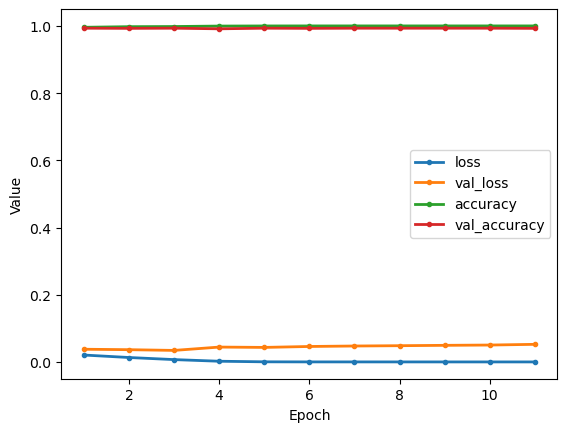

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/87 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step

 6/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step  

11/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

36/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

41/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

46/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

51/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

56/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

61/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

66/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

72/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

77/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

83/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


 1/87 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step

 6/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

11/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/87 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

36/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

41/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

46/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

51/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

56/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

61/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

66/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

71/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

76/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

82/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/MIKC_MADS/report_ZT5TNTQ0.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################